In [7]:
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

from tensorflow.keras import regularizers

from keras.optimizers import SGD, Adam, RMSprop

In [8]:
import glob
import pandas as pd
import math
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
all_filenames = [i for i in glob.glob('/content/drive/My Drive/TrainingData/*.{}'.format('csv'))]

In [11]:
df_x, df_x_time, df_y, df_y_time = [], [], [], []
for f in all_filenames:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df_y_time.append(df)
    
x = pd.concat(df_x, ignore_index=True)
x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
x_time = pd.concat(df_x_time, ignore_index=True)
x_time.columns = ['x_time']
y = pd.concat(df_y, ignore_index=True)
y.columns = ['y', 'subject', 'subject_ID']
y_time = pd.concat(df_y_time, ignore_index=True)
y_time.columns = ['y_time']
x['time'] = x_time['x_time']
y['time'] = y_time['y_time']

In [12]:
x.head()

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,001,01,0.000
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,001,01,0.025
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,001,01,0.050
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,001,01,0.075
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,001,01,0.100


In [14]:
y['time'] = [x+0.005 for x in y['time']]

In [15]:
y.head()

,y,subject,subject_ID,time
0,0,001,01,0.025
1,0,001,01,0.125
2,0,001,01,0.225
3,0,001,01,0.325
4,0,001,01,0.425


In [16]:
train_df = pd.merge(x,y, on=['time','subject', 'subject_ID'])

In [17]:
train_df.shape

(269410, 10)

In [102]:
# This is the number of hidden units in the RNN layer
hidden_size = 100
# This is the rate for the dropout layer
rate_dropout = 0.5
num_steps = 6

# TODO: Complete the definition of the network using a single simple RNN layer
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=6, output_dim= hidden_size, input_length=hidden_size))
model_RNN.add(Bidirectional(LSTM(hidden_size, activation='tanh', return_sequences=True, dropout=rate_dropout)))
model_RNN.add(TimeDistributed(Dense(100)))
model_RNN.add(Dense(4, activation='softmax'))
model_RNN.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
model_RNN.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          600       
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 100, 100)          20100     
_________________________________________________________________
dense_18 (Dense)             (None, 100, 4)            404       
Total params: 181,904
Trainable params: 181,904
Non-trainable params: 0
_________________________________________________________________


In [87]:
model_RNN.output_shape

(None, 6, 4)

In [88]:
# This is the number of hidden units in the RNN layer
hidden_size = 500
# This is the rate for the dropout layer
rate_dropout = 0.5
num_steps = 6

# TODO: Complete the definition of the network using a single simple RNN layer
model = Sequential()
model.add(Embedding(130, 128, input_length=num_steps))
model.add(Dropout(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 6, 128)            16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 128)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 260       
Total params: 66,308
Trainable params: 66,308
Non-trainable params: 0
_________________________________________________________________


In [110]:
train_df.shape[1:]

(10,)

In [147]:
# Simple CNN
model = Sequential() 
model.add(Flatten(input_shape=(6,))) 
model.add(Dense(10000, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1000, activation='sigmoid')) 
model.add(Dropout(0.3)) 
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=Adam(),
   metrics=['acc'])

In [148]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 6)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 10000)             70000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 10000)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 1000)              10001000  
_________________________________________________________________
dropout_27 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 4004      
Total params: 10,075,004
Trainable params: 10,075,004
Non-trainable params: 0
_________________________________________

In [42]:
model.input_shape

(None, 6)

In [43]:
model.output_shape

(None, 4)

In [44]:
train_df.head()

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time,y
0,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,001,01,0.025,0
1,4.226515,8.273807,2.851742,0.012534,0.000445,-0.016830,001,01,0.125,0
2,4.432763,8.272613,2.790050,-0.002715,0.023094,0.012222,001,01,0.225,0
3,4.524325,8.446963,2.874356,-0.003438,0.036310,0.045451,001,01,0.325,0
4,4.788242,8.201208,2.805275,-0.009608,0.032156,0.025749,001,01,0.425,0


In [21]:
# Oversampling using SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(train_df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']], train_df['y'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [125]:
kf = KFold(n_splits=4)
for train_index, test_index in kf.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

TRAIN: [200126 200127 200128 ... 800501 800502 800503] TEST: [     0      1      2 ... 200123 200124 200125]
TRAIN: [     0      1      2 ... 800501 800502 800503] TEST: [200126 200127 200128 ... 400249 400250 400251]
TRAIN: [     0      1      2 ... 800501 800502 800503] TEST: [400252 400253 400254 ... 600375 600376 600377]
TRAIN: [     0      1      2 ... 600375 600376 600377] TEST: [600378 600379 600380 ... 800501 800502 800503]


In [126]:
y_train.shape

(600378,)

In [22]:
unique, counts = np.unique(y, return_counts=True)

In [23]:
print(unique)
print(counts)

[0 1 2 3]
[200126 200126 200126 200126]


In [129]:
X_train = X_train.reshape(-1,6)
X_test = X_test.reshape(-1,6)

In [130]:
y_train = to_categorical(y_train,4).reshape(-1,4)
y_test = to_categorical(y_test,4).reshape(-1,4)

In [1]:
X.shape

NameError: ignored

In [149]:
model_history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test))

Epoch 1/10
  114/18762 [..............................] - ETA: 30:06 - loss: 1.5375 - acc: 0.3172

KeyboardInterrupt: ignored

In [144]:
import matplotlib.pyplot as plt

def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

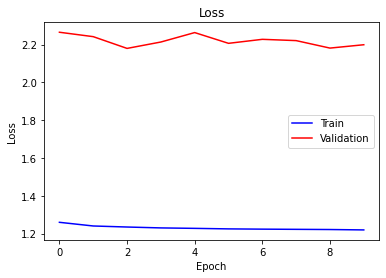

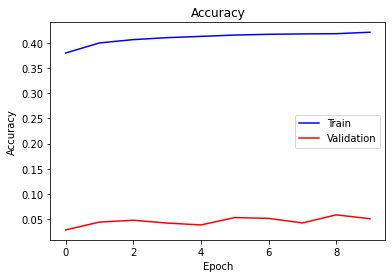

In [145]:
plot_history(model_history)